#### Methodology to address fundamental problem 1 itemized in Issue 1024 - follow-up compare tabulations and relative household burden. This time I extend the 12-11 notebook to look at how the percentile ranks affects the proportion of tracts considered as burdened versus the current methodology.

### Indicator reviewed: 

Socioeconomic Factors Indicator reviewed
*  [Extreme Housing Burden](#housingburden)

#### Packages

In [1]:
import math
import numpy as np
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cenpy import products
%matplotlib inline

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### ETL process for acquiring relevant tables

#### NOTE: If you ran the ETL Process to acquire Table 8 in the other notebook of this draft PR you do not need to run the ETL cell block again

In [3]:
# Copy and adapt certain sections of code from data_pipeline.utils 

def download_hud_dataset():
    DOWNLOAD_FILENAME = "HUD_ZIPPED.csv"
    HOUSING_FTP_URL = "https://www.huduser.gov/portal/datasets/cp/2014thru2018-140-csv.zip"    
    response = requests.get(HOUSING_FTP_URL, verify=True)
    if response.status_code == 200:
        file_contents = response.content
    else:
        sys.exit(
            f"HTTP response {response.status_code} from url {file_url}. Info: {response.content}"
        )

    # Write the contents to disk.
    file = open(DOWNLOAD_FILENAME, "wb")
    file.write(file_contents)
    file.close()
    
def extract_zipped_download(zip_file_path, unzipped_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(unzipped_path)
    # cleanup temporary file
    os.remove(zip_file_path)
    
def up_one_directory(path):
    try:
        # from Python 3.6
        parent_dir = Path(path).parents[1]
        # for Python 3.4/3.5, use str to convert the path to string
        # parent_dir = str(Path(path).parents[1])
        shutil.move(path, parent_dir)
    except IndexError:
        # no upper directory
        pass

CURRENT_DIRECTORY = os.getcwd()
download_hud_dataset()
extract_zipped_download(CURRENT_DIRECTORY + "/HUD_ZIPPED.csv", CURRENT_DIRECTORY)  
up_one_directory(CURRENT_DIRECTORY + "/140/Table8.csv")
shutil.rmtree("./140/")

### Extreme Housing Burden <a id='housingburden'></a>

The Extreme Housing Burden indicator represents the proportion of low-income households that have to spend more than half their income on rent. These households experience higher levels of stress, report lower health, and may delay medical treatment because of its high cost.

The Extreme Housing Burden indicator measures the percent of households in a census tract that are:

1. Making less than 80% of the Area Median Family Income as determined by the Department of Housing and Urban Development (HUD), and
2. Paying greater than 50% of their income to housing costs. 

This data is sourced from the 2014-2018 Comprehensive Housing Affordability Strategy dataset from the Department of Housing and Urban Development (HUD) using the census tract geographic summary level, and contains cost burdens for households by percent HUD-adjusted median family income (HAMFI) category. This data can be found [here](https://www.huduser.gov/portal/datasets/cp.html). 

Because CHAS data is based on American Communities Survey (ACS) estimates, which come from a sample of the population, they may be unreliable if based on a small sample or population size.

The standard error and relative standard error were used to evaluate the reliability of each estimate using CalEnviroScreen’s methodology. 

Census tract estimates that met either of the following criteria were considered reliable and included in the analysis [(CalEnviroScreen, 2017, page 129)](https://oehha.ca.gov/media/downloads/calenviroscreen/report/ces3report.pdf ):

- Relative standard error less than 50 (meaning the standard error was less than half of the estimate), OR 
- Standard error less than the mean standard error of all census tract estimates 

Formulas for calculating the standard error of sums, proportions, and ratio come from the [American Communities Survey Office](https://www2.census.gov/programs-surveys/acs/tech_docs/accuracy/MultiyearACSAccuracyofData2013.pdf).

Note that this code creates a score and rank by state, for every state.

The relevant variables in table 8 of the CHAS dataset are the following (CHAS data dictionary available [here](https://www.huduser.gov/portal/datasets/cp/CHAS-data-dictionary-14-18.xlsx)):

|   Name  |                          Label                      |
|---------|-----------------------------------------------------|
|T1_est1  |                                   Total Occupied housing units                                      | 
|T8_est10 |            Owner occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est23 |Owner occupied greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est36 |Owner occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
|T8_est76 |           Renter occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est89 |Renter occupied	greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est102|Renter occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
 

### Below I also propose an alternate means for ranking census tracts
### These steps are outlined and commented below

In [2]:
# Read in the data from https://www.huduser.gov/portal/datasets/cp.html
housing = pd.read_csv("Table8.csv", 
                      encoding = "ISO-8859-1",  
                      dtype = {'Tract_ID': object, 'st': object, 'geoid': object})

# Remove data for states that aren't included in the census (e.g. American Samoa, Guam, etc.):
housing.drop(housing.loc[housing['st'] == '72'].index, inplace = True)

# Combine owner and renter occupied low-income households that make less than 80% of HAMFI into one variable
housing['summed'] = (housing['T8_est10'] + 
                     housing['T8_est23'] + 
                     housing['T8_est36'] + 
                     housing['T8_est76'] + 
                     housing['T8_est89'] + 
                     housing['T8_est102'])

# Create a variable for the standard error of the summed variables
housing['summed_se'] = np.sqrt((housing['T8_moe10'] / 1.645)**2 + 
                                (housing['T8_moe23'] / 1.645)**2 + 
                                (housing['T8_moe36'] / 1.645)**2 + 
                                (housing['T8_moe76'] / 1.645)**2 + 
                                (housing['T8_moe89'] / 1.645)**2 + 
                                (housing['T8_moe102'] / 1.645)**2)

# Remove the first 7 digits in the FIPS Census Tract ID 
housing['geoid'] = housing['geoid'].str[-11:]

# Find the estimate of the proportion of the population that is heavily rent burdened
housing['hbrd_score'] = housing['summed'] / housing['T8_est1']

# Change rates where the population is 0 to nan
housing['hbrd_score'].replace(np.inf, np.nan, inplace = True)

# Create function for calculating the standard error, using the proportions standard error formula
#  if the value under the radical is negative, use the ratio standard error formula
def se_prop(x, y, se_x, moe_y): 
    se_y = moe_y / 1.645
    test = se_x**2 - (((x**2)/(y**2))*((se_y)**2))
    se = np.where(test < 0,
                   (1/y) * np.sqrt(se_x**2 + (((x**2)/(y**2))*(se_y**2))), 
                   (1/y) * np.sqrt(se_x**2 - (((x**2)/(y**2))*(se_y**2))))
    return se

housing['se'] = se_prop(housing['summed'], housing['T8_est1'], housing['summed_se'], housing['T8_moe1'])

# Calculate the relative standard error
housing['rse'] = housing['se'] / housing['hbrd_score']*100

# Change infinite rse's where the housing burden is 0 to np.nan
housing['rse'].replace(np.inf, np.nan, inplace = True)

# Calculate the mean standard error for each state
housing['mean_state_se'] = np.zeros(len(housing))

for state in housing['st'].unique():
    mean_se = np.mean(housing[housing['st'] == state]['se'])
    housing['mean_state_se'].loc[housing['st'] == state] = mean_se
    
# Find census tract estimates that meet both of the following criteria and are thus considered unreliable estimates: 
# RSE less than 50 AND
# SE less than the mean state SE or housing burdened low income households
# Convert these scores to nan
housing.loc[(housing['rse'] >= 50) & (housing['rse'] >= housing['mean_state_se']), 'hbrd_score'] = np.nan

# Rename columns
housing = housing.rename(columns = {'geoid' :'FIPS_tract_id',
                                    'st' : 'state'
                                   })

# Calculate percentile rank for census tracts with a score above 0, set percentile to 0 if score is 0, for each state
housing['hbrd_rank'] = housing[
            housing['hbrd_score'] != 0][['hbrd_score',
                'state']].groupby('state').rank( 
                na_option = 'keep', 
                pct = True) * 100

housing.loc[housing['hbrd_score'] == 0, 'hbrd_rank'] = 0

# Create final housing burden df
housingburden = housing.copy()

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [3]:
housingburden.head()

,source,sumlevel,FIPS_tract_id,name,state,cnty,tract,T8_est1,T8_est2,T8_est3,...,T8_moe131,T8_moe132,T8_moe133,summed,summed_se,hbrd_score,se,rse,mean_state_se,hbrd_rank
0,2014thru2018,140,01001020100,"Census Tract 201, Autauga County, Alabama",01,1,20100,765,570,50,...,12,12,12,80,31.721807,0.104575,0.041032,39.237314,0.036604,46.298077
1,2014thru2018,140,01001020200,"Census Tract 202, Autauga County, Alabama",01,1,20200,720,465,65,...,12,12,12,138,45.531874,0.191667,0.061614,32.146659,0.036604,83.269231
2,2014thru2018,140,01001020300,"Census Tract 203, Autauga County, Alabama",01,1,20300,1295,840,60,...,12,12,12,170,53.722921,0.131274,0.040927,31.176999,0.036604,63.653846
3,2014thru2018,140,01001020400,"Census Tract 204, Autauga County, Alabama",01,1,20400,1640,1260,15,...,12,12,12,145,46.288510,0.088415,0.027822,31.467397,0.036604,34.615385
4,2014thru2018,140,01001020500,"Census Tract 205, Autauga County, Alabama",01,1,20500,4175,2320,175,...,17,17,17,595,147.221693,0.142515,0.034760,24.390193,0.036604,68.221154


In [4]:
housingburden.shape

(73056, 280)

### As desired we see a uniform distribution for the percentile rank for burdened households

### Now we compute for a baseline comparison 

In [5]:
# Owner occupied numerator fields
OWNER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est7",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est10",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est20",
    
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est23",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est33",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est36",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
OWNER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est13",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est26",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est39",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est52",
    #   Subtotal
    #   Owner occupied
    #   greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est65",
    #   Subtotal
    #   Owner occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

OWNER_OCCUPIED_POPULATION_FIELD = "T8_est2"
#   Subtotal
#   Owner occupied
#   All
#   All
#   All

OWNER_OCCUPIED_POPULATION_HAMFI_FIELD = "T8_est3"
#   Subtotal
#   Owner occupied 
#   All
#   All
#   All

# Renter occupied numerator fields
RENTER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est73",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est76",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est86",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est89",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est99",
    #   Subtotal
    #   Renter occupied	greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est102",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
RENTER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est79",
    #   Subtotal
    #   Renter occupied	less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est92",
    #   Subtotal
    #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est105",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est118",
    #   Subtotal
    #   Renter occupied	greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est131",
    #   Subtotal
    #   Renter occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

# T8_est68	SubtotalRenter occupied	All	All	All
RENTER_OCCUPIED_POPULATION_FIELD = "T8_est68"

In [6]:
housingburden["current_summed_methodology"] = housingburden[
    OWNER_OCCUPIED_NUMERATOR_FIELDS
].sum(axis=1) + housingburden[RENTER_OCCUPIED_NUMERATOR_FIELDS].sum(axis=1)

In [7]:
housingburden["current_methodology_denominator"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
            - housingburden[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
            - housingburden[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

In [8]:
housingburden["current_methodology_denominator_sans_not_computed"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
)

In [9]:
housingburden["current_methodology_percent"] = np.round(
    (housingburden["current_summed_methodology"] / housingburden["current_methodology_denominator"] ), 2) * 100

### Now we construct the distribution of differences in the number of owned and rented burdened households


### Percentiles Comparison

In [10]:
final_df = housingburden[['FIPS_tract_id', 'state','hbrd_rank','hbrd_score', 'summed', 
       'current_summed_methodology', 'T8_est1', 
        "current_methodology_denominator_sans_not_computed",
       'current_methodology_denominator',  'current_methodology_percent']]

##### First notice here that **T8_est1** and **current_methodology_denominator** should represent same or similar aggregates. In general, we cen see that the current computation performed results in a differerntial that undercounts the total occupied and rental households.

In [11]:
final_df["differences_aggregate_denominator"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
final_df["differences_aggregate_denominator_sans_not_computed"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:title={'center':'Distribution of differences between aggregate totals that normalizes tabulation of poverty households'}, xlabel='Aggregate differences in total owner and renter occupied low-income households < 80%', ylabel='Relative Frequency in Support'>

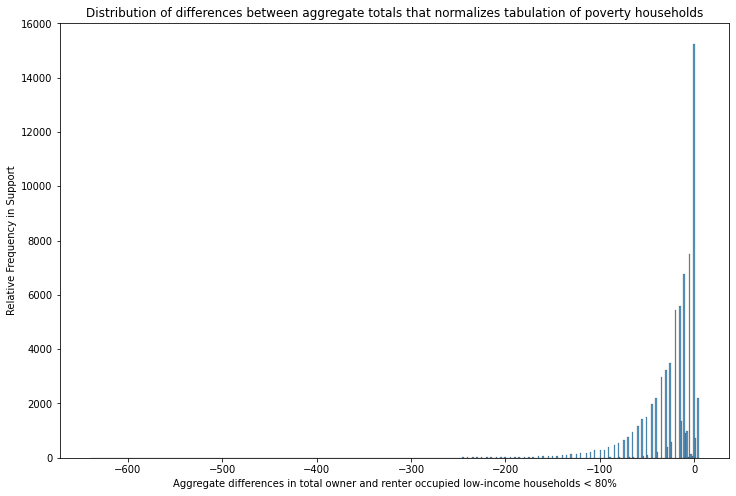

In [13]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households < 80%')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator"])

<AxesSubplot:title={'center':'Distribution of differences between aggregate totals that normalizes tabulation of poverty households (with removal of not computed fields) '}, xlabel='Aggregate differences in total owner and renter occupied low-income households', ylabel='Relative Frequency in Support'>

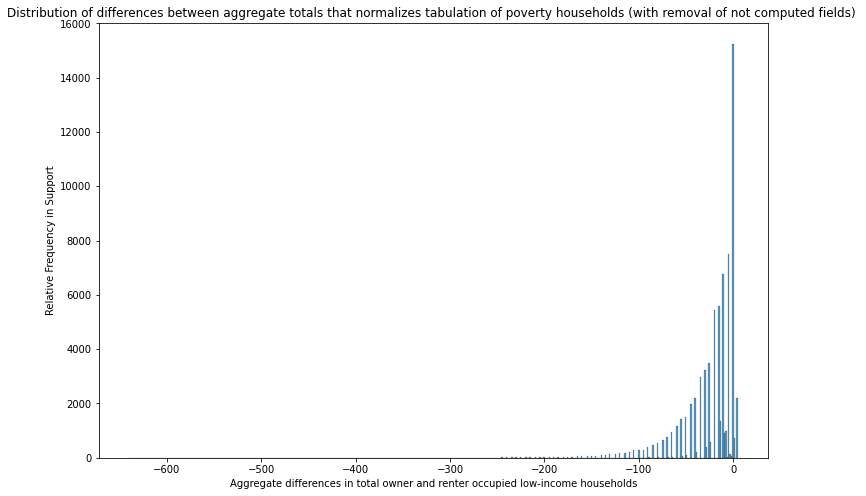

In [14]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households (with removal of not computed fields) ')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator_sans_not_computed"])

In [15]:
final_df["current_methodology_percentile_rank"] = final_df["current_methodology_percent"].rank(
    pct=True,
    # Set ascending to the parameter value.
    ascending=True,
)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
final_df["new_threshold_exceeded"] = (final_df['hbrd_rank'] >= 90)

final_df["current_threshold_exceeded"] = (final_df[
    'current_methodology_percentile_rank'] >= 0.90)

/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sarahluw/.pyenv/versions/3.6.2/envs/my-virtual-env-3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Only include non-NA tracts for comparison purposes

In [17]:
# first save NA tracts that were considered unreliable
ineligible_tracts = list(final_df[final_df["hbrd_rank"].isna()]["FIPS_tract_id"].values)

In [18]:
len(ineligible_tracts)

5243

#### How many tracts are ineligible according to CalEnvironScreen but are considerd in Score L?




In [19]:
final_current_methodology = final_df[final_df["current_methodology_percentile_rank"] >= 0.90]

In [20]:
final_current_methodology.shape

(7323, 15)

In [21]:
# 53 tracts
final_current_methodology[
    final_current_methodology.FIPS_tract_id.isin(ineligible_tracts)].shape

(53, 15)

In [22]:
non_null_df = final_df.copy()

In [23]:
non_null_df.to_csv("comparison_df_final.csv")

In [24]:
# number of tracks eligible
non_null_df[non_null_df["current_methodology_percentile_rank"] >= 0.90].shape

(7323, 15)

<AxesSubplot:title={'center':'Distribution for Housing Burden (Score L) after application of ranked percentiles'}, xlabel='Relative burden (although currently not represented as a percentage)', ylabel='Relative Frequency in Support'>

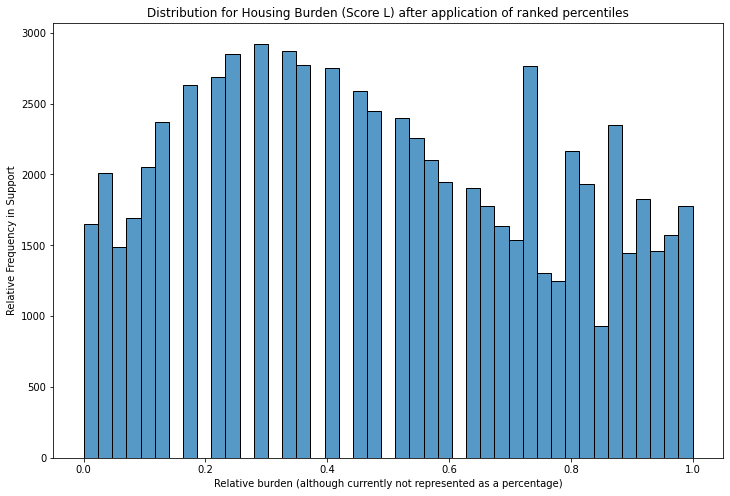

In [43]:
plt.figure(figsize=(12, 8))
plt.title("Distribution for Housing Burden (Score L) after application of ranked percentiles")
# Set x-axis label
plt.xlabel('Relative burden (although currently not represented as a percentage)')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(non_null_df["current_methodology_percentile_rank"])

In [26]:
non_null_df["current_threshold_exceeded"].value_counts()

False    65733
True      7323
Name: current_threshold_exceeded, dtype: int64

In [27]:
non_null_df["new_threshold_exceeded"].value_counts()

False    66255
True      6801
Name: new_threshold_exceeded, dtype: int64

In [28]:
# (non_null_df["new_threshold_exceeded"] == True)

### Score L Criterion as burden but not CalEnvironscreen

In [29]:
# this includes uineligible np.nan values too
predicate_1 = (non_null_df['current_threshold_exceeded'] == True) & (non_null_df['new_threshold_exceeded'] != True)

non_null_df[predicate_1].shape

(2794, 15)

In [30]:
# Where Score L is considered burdened but not in CalEnviroScreen
score_l_considered_burdened = non_null_df[predicate_1]

In [31]:
import us

mapping = us.states.mapping('fips', 'abbr')

In [32]:
# Inserted after the basic stats definition.
# Load demographic data
import pathlib

DATA_DIR = pathlib.Path.cwd().parent / "data"
COMPARISON_OUTPUTS_DIR = DATA_DIR / "comparison_outputs"

demographics_path = DATA_DIR / "dataset" / "census_acs_2019" / "usa.csv"

demographics_df = pd.read_csv(
    demographics_path,
    dtype={"GEOID10_TRACT": "string"},
)

# Set some field names
BLACK_FIELD_NAME = "Black or African American alone"
AMERICAN_INDIAN_FIELD_NAME = "American Indian and Alaska Native alone"
ASIAN_FIELD_NAME = "Asian alone"
HAWAIIAN_FIELD_NAME = "Native Hawaiian and Other Pacific alone"
TWO_OR_MORE_RACES_FIELD_NAME = "Two or more races"
NON_HISPANIC_WHITE_FIELD_NAME = "Non-Hispanic White"
HISPANIC_FIELD_NAME = "Hispanic or Latino"
PERCENT_PREFIX = "Percent "

RE_OUTPUT_FIELDS = [
    BLACK_FIELD_NAME,
    AMERICAN_INDIAN_FIELD_NAME,
    ASIAN_FIELD_NAME,
    HAWAIIAN_FIELD_NAME,
    TWO_OR_MORE_RACES_FIELD_NAME,
    NON_HISPANIC_WHITE_FIELD_NAME,
    HISPANIC_FIELD_NAME,
]

RE_PERCENT_OUTPUT_FIELDS = [PERCENT_PREFIX + field for field in RE_OUTPUT_FIELDS]

columns_to_keep = (
    ["GEOID10_TRACT"]
    + RE_OUTPUT_FIELDS
    + RE_PERCENT_OUTPUT_FIELDS
    + ['Percent of individuals < 200% Federal Poverty Line', 
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
        'Percent enrollment in college or graduate school',
        'Linguistic isolation (percent)']
)


def highlight_medians(s):
    # highlight if the current median is greater than the median of medians for that series
    is_greater_than_median = s > s.median()
    return ['color: pink; background-color:#7272FE'
            if cell else '' for cell in is_greater_than_median]
# Join the demographics in.
merged_df_score_l = score_l_considered_burdened.merge(
    demographics_df[columns_to_keep],
    left_on="FIPS_tract_id",
    right_on="GEOID10_TRACT",
    how="inner"
)

# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in merged_df_score_l.columns if 
                'Percent' in x or '(percent)' in x
    ]

merged_df_score_l[
    percent_cols] = merged_df_score_l[
    percent_cols].apply(lambda x: x * 100)

for idx, row in merged_df_score_l.iterrows():
    current_row = str(merged_df_score_l.loc[idx, 'state'])
    state = mapping.get(current_row, None)
    merged_df_score_l.loc[idx, 'state_name'] = state

grouped_stats_score_l = merged_df_score_l.groupby(["state_name"]).agg({
       'GEOID10_TRACT': 'nunique',
       'Percent of individuals < 200% Federal Poverty Line': [np.median, np.std],
       'Median value ($) of owner-occupied housing units': [np.median, np.std],
       'Percent individuals age 25 or over with less than high school degree': [np.median, np.std],
       'Percent enrollment in college or graduate school': [np.median, np.std],
       'Percent Black or African American alone': [np.median, np.std],
       'Percent American Indian and Alaska Native alone': [np.median, np.std],
       'Percent Non-Hispanic White': [np.median, np.std], 
      'Linguistic isolation (percent)': [np.median, np.std],
       'Percent Hispanic or Latino': [np.median, np.std],
      'hbrd_rank': [np.median, np.std],
      'current_methodology_percent': [np.median, np.std],
      'current_summed_methodology': [np.median, np.std, np.sum]
}).reset_index()


grouped_stats_score_l.columns = [' '.join(col).strip() for 
                                 col in grouped_stats_score_l.columns.values]

grouped_stats_score_l = grouped_stats_score_l[[x for x in grouped_stats_score_l 
               if "median" in x and 
               "Percent" in x] + ["GEOID10_TRACT nunique", 
                                  'current_summed_methodology sum', "state_name"]]

grouped_stats_score_l.set_index("state_name", inplace=True)

grouped_stats_score_l = grouped_stats_score_l.rename(columns={
'Percent of individuals < 200% Federal Poverty Line median'
    : 'Percent of individuals < 200% Federal Poverty Line (median across all tracts)', 
'Percent individuals age 25 or over with less than high school degree median':
'Percent individuals age 25 or over with less than high school degree (median across all tracts)',    
'Percent enrollment in college or graduate school median'
    :'Percent enrollment in college or graduate school (median across all tracts)',
'Percent Black or African American alone median':
    'Percent Black or African American alone (median across all tracts)',
'Percent American Indian and Alaska Native alone median':
    'Percent American Indian and Alaska Native alone (median across all tracts)',
'Percent Non-Hispanic White median':
    'Percent Non-Hispanic White (median across all tracts)',
'Percent Hispanic or Latino median':
    'Percent Hispanic or Latino (median across all tracts)',
'GEOID10_TRACT nunique': "Total Number of Unique Tracts",
"current_summed_methodology sum": "Total Owned and Rented Burdened Households (Current Aggregation Methodology)"    
})

In [33]:
merged_df_score_l.shape

(2794, 36)

In [34]:
merged_df_score_l.to_csv("./experiment_4_texas_example/merged_df_score_l_2794.csv")

In [35]:
grouped_stats_score_l.columns

Index(['Percent of individuals < 200% Federal Poverty Line (median across all tracts)',
       'Percent individuals age 25 or over with less than high school degree (median across all tracts)',
       'Percent enrollment in college or graduate school (median across all tracts)',
       'Percent Black or African American alone (median across all tracts)',
       'Percent American Indian and Alaska Native alone (median across all tracts)',
       'Percent Non-Hispanic White (median across all tracts)',
       'Percent Hispanic or Latino (median across all tracts)',
       'Total Number of Unique Tracts',
       'Total Owned and Rented Burdened Households (Current Aggregation Methodology)'],
      dtype='object')

In [36]:
top_10_represented_score_l = list(merged_df_score_l["state_name"].value_counts()[:10].keys())

In [37]:
representative_score_l = merged_df_score_l[
    merged_df_score_l.state_name.isin(top_10_represented_score_l)]

representative_score_l.shape[0] / merged_df_score_l.shape[0] * 100

81.53185397279886

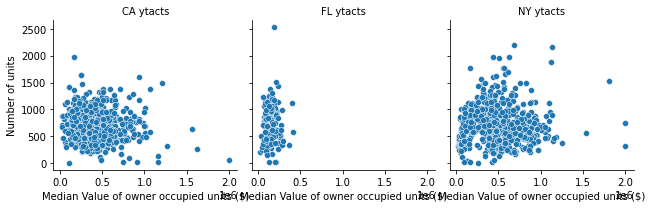

In [38]:
g = sns.FacetGrid(representative_score_l[
    representative_score_l.state_name.isin(top_10_represented_score_l[:3])], 
                  col="state_name", 
                   margin_titles=True)
g.map_dataframe(sns.scatterplot, x="Median value ($) of owner-occupied housing units", 
                y="current_summed_methodology")
g.set_axis_labels("Median Value of owner occupied units ($)", "Number of units")
g.set_titles(col_template="{col_name} ytacts", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
g.tight_layout()

Text(0.5, 0.98, 'Empirical CDF of 81% of the 2794 tracts that are considered burdened using Score L')

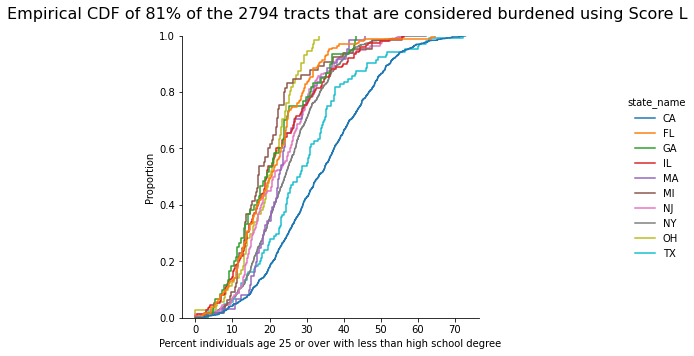

In [39]:
ax2 = sns.displot(data=representative_score_l,
            x='Percent individuals age 25 or over with less than high school degree', hue="state_name", kind="ecdf")

ax2.fig.subplots_adjust(top=0.9)
ax2.fig.suptitle("Empirical CDF of 81% of the 2794 tracts that are considered burdened using Score L", fontsize=16)

In [42]:
representative_score_l.state_name.value_counts()

CA    847
NY    596
FL    163
NJ    160
IL    151
TX    104
OH     71
MI     65
MA     61
GA     60
Name: state_name, dtype: int64

Text(0.5, 0.98, 'Empirical CDF of 81% of the 2794 tracts that are considered burdened using Score L')

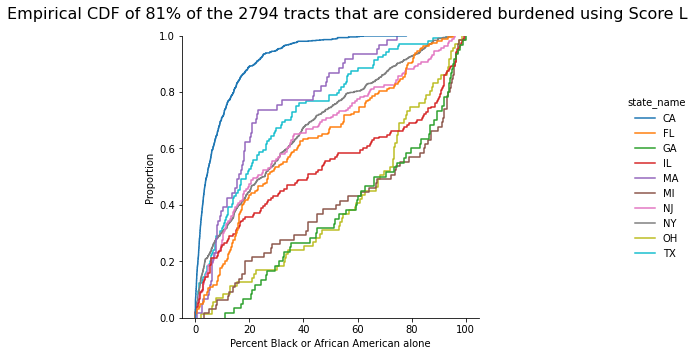

In [40]:
# split - WA, AZ exceptions

ax1 = sns.displot(data=representative_score_l,
            x="Percent Black or African American alone", hue="state_name", kind="ecdf")

ax1.fig.subplots_adjust(top=0.9)
ax1.fig.suptitle("Empirical CDF of 81% of the 2794 tracts that are considered burdened using Score L", fontsize=16)

Text(0.5, 0.98, 'Empirical CDF of 81% of the 2794 tracts that are considered burdened using Score L')

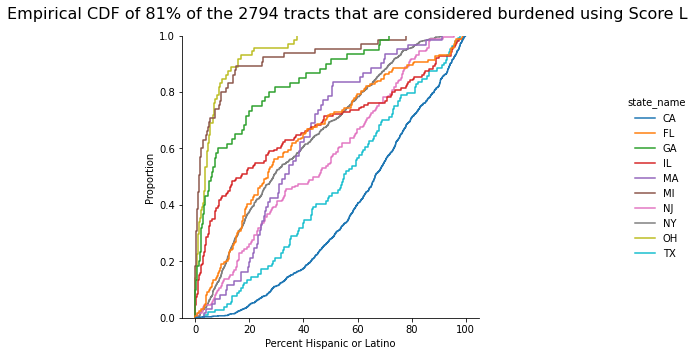

In [41]:
ax = sns.displot(data=representative_score_l,
            x="Percent Hispanic or Latino", hue="state_name", kind="ecdf")

ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle("Empirical CDF of 81% of the 2794 tracts that are considered burdened using Score L", fontsize=16)

If the samples are samples from the population - a big assumption - in question and the sampling follows rules and things we take the mean:

The mean of the median distribution (an order statistic) is the best estimate for the median. It's the best least unbiased estimator. The answer is not the median of that distribution.

The answer is also not if the mean is an estimate of the median. Completely unrelated.

Even if the original population is skewed, the distribution of a sampling statistic will be normalized - recall the the central limit theorem for more details

The standard error of that mean should give you what you want to know to confidently make statements of the true population median across all states

In [32]:
list_of_columns = list(grouped_stats_score_l.columns)
values_1 = list(grouped_stats_score_l[list_of_columns].mean())

In [33]:
values_1.extend([True, False])

In [34]:
values_1

[57.05272445515469,
 19.383812769449793,
 8.132533443213486,
 33.69280603472747,
 1.2213947311592683,
 31.32188596954498,
 19.378347515748676,
 62.08888888888889,
 40949.2,
 True,
 False]

# CalenviroScreen Burden

In [45]:
predicate_2 = (non_null_df['current_threshold_exceeded'] == False) & (non_null_df['new_threshold_exceeded'] == True)

cal_ej_screen_burdened = non_null_df[predicate_2]

In [46]:
# Join the demographics in.
merged_df_score_ejcreen = cal_ej_screen_burdened.merge(
    demographics_df[columns_to_keep],
    left_on="FIPS_tract_id",
    right_on="GEOID10_TRACT",
    how="inner"
)

# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in merged_df_score_ejcreen.columns if 
                'Percent' in x or '(percent)' in x
    ]

merged_df_score_ejcreen[
    percent_cols] = merged_df_score_ejcreen[
    percent_cols].apply(lambda x: x * 100)

for idx, row in merged_df_score_ejcreen.iterrows():
    current_row = str(merged_df_score_ejcreen.loc[idx, 'state'])
    state = mapping.get(current_row, None)
    merged_df_score_ejcreen.loc[idx, 'state_name'] = state

grouped_stats_score_ej_screen = merged_df_score_ejcreen.groupby(["state_name"]).agg({
       'GEOID10_TRACT': 'nunique',
       'Percent of individuals < 200% Federal Poverty Line': [np.median, np.std],
       'Median value ($) of owner-occupied housing units': [np.median, np.std],
       'Percent individuals age 25 or over with less than high school degree': [np.median, np.std],
       'Percent enrollment in college or graduate school': [np.median, np.std],
       'Percent Black or African American alone': [np.median, np.std],
       'Percent American Indian and Alaska Native alone': [np.median, np.std],
       'Percent Non-Hispanic White': [np.median, np.std], 
      'Linguistic isolation (percent)': [np.median, np.std],
       'Percent Hispanic or Latino': [np.median, np.std],
      'hbrd_rank': [np.median, np.std],
      'current_methodology_percent': [np.median, np.std],
      'current_summed_methodology': [np.median, np.std, np.sum]
}).reset_index()


grouped_stats_score_ej_screen.columns = [' '.join(col).strip() for 
                                 col in grouped_stats_score_ej_screen.columns.values]

grouped_stats_score_ej_screen = grouped_stats_score_ej_screen[[x for x in grouped_stats_score_ej_screen 
               if "median" in x and 
               "Percent" in x] + ["GEOID10_TRACT nunique", 
                                  'current_summed_methodology sum', "state_name"]]

grouped_stats_score_ej_screen.set_index("state_name", inplace=True)

grouped_stats_score_ej_screen = grouped_stats_score_ej_screen.rename(columns={
'Percent of individuals < 200% Federal Poverty Line median'
    : 'Percent of individuals < 200% Federal Poverty Line (median across all tracts)', 
'Percent individuals age 25 or over with less than high school degree median':
'Percent individuals age 25 or over with less than high school degree (median across all tracts)',    
'Percent enrollment in college or graduate school median'
    :'Percent enrollment in college or graduate school (median across all tracts)',
'Percent Black or African American alone median':
    'Percent Black or African American alone (median across all tracts)',
'Percent American Indian and Alaska Native alone median':
    'Percent American Indian and Alaska Native alone (median across all tracts)',
'Percent Non-Hispanic White median':
    'Percent Non-Hispanic White (median across all tracts)',
'Percent Hispanic or Latino median':
    'Percent Hispanic or Latino (median across all tracts)',
'GEOID10_TRACT nunique': "Total Number of Unique Tracts",
"current_summed_methodology sum": "Total Owned and Rented Burdened Households (Current Aggregation Methodology)"    
})

In [123]:
top_10_represented = list(merged_df_score_ejcreen["state_name"].value_counts()[:10].keys())

In [124]:
merged_df_score_ejcreen.shape

(2272, 36)

In [125]:
# merged_df_score_ejcreen.to_csv("./experiment_4_texas_example/merged_df_score_ejcreen_2272.csv")

In [126]:
representative_calenvironscreen = merged_df_score_ejcreen[
    merged_df_score_ejcreen.state_name.isin(top_10_represented)]

representative_calenvironscreen.shape[0] / merged_df_score_ejcreen.shape[0] * 100

43.221830985915496

In [128]:
merged_df_score_ejcreen["state_name"].value_counts()[:5]

TX    206
PA    114
WA     93
NC     90
MN     89
Name: state_name, dtype: int64

In [51]:
cdc_places = pd.read_csv("../data/dataset/cdc_places/usa.csv")

cdc_le = pd.read_csv("../data/dataset/cdc_life_expectancy/usa.csv")

# all CDC datasets
temp_cdc = cdc_places.merge(cdc_le, on = "GEOID10_TRACT")

In [85]:
representative_calenvironscreen.columns

Index(['FIPS_tract_id', 'state', 'hbrd_rank', 'hbrd_score', 'summed',
       'current_summed_methodology', 'T8_est1',
       'current_methodology_denominator_sans_not_computed',
       'current_methodology_denominator', 'current_methodology_percent',
       'differences_aggregate_denominator',
       'differences_aggregate_denominator_sans_not_computed',
       'current_methodology_percentile_rank', 'new_threshold_exceeded',
       'current_threshold_exceeded', 'GEOID10_TRACT',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Other Pacific alone', 'Two or more races',
       'Non-Hispanic White', 'Hispanic or Latino',
       'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Asian alone',
       'Percent Native Hawaiian and Other Pacific alone',
       'Percent Two or more races', 'Percent Non-Hispanic White',
       'Percent Hispanic o

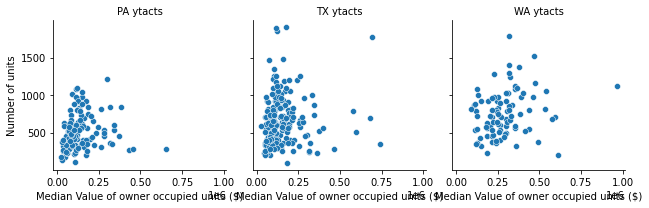

In [129]:
g = sns.FacetGrid(representative_calenvironscreen[
    representative_calenvironscreen.state_name.isin(top_10_represented[:3])], 
                  col="state_name", 
                   margin_titles=True)
g.map_dataframe(sns.scatterplot, x="Median value ($) of owner-occupied housing units", 
                y="current_summed_methodology")
g.set_axis_labels("Median Value of owner occupied units ($)", "Number of units")
g.set_titles(col_template="{col_name} ytacts", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
g.tight_layout()

Text(0.5, 0.98, 'Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB')

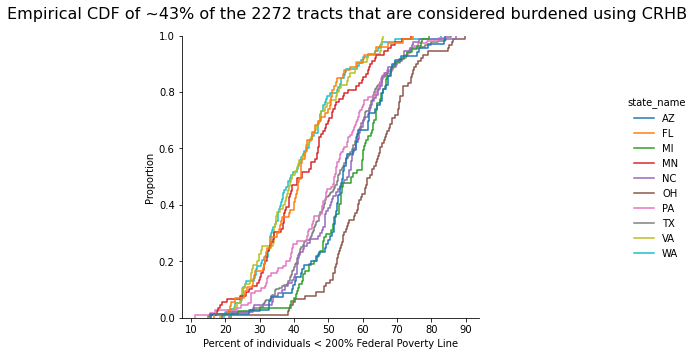

In [147]:
ax2 = sns.displot(data=representative_calenvironscreen,
    x='Percent of individuals < 200% Federal Poverty Line', hue="state_name", kind="ecdf")

ax2.fig.subplots_adjust(top=0.9)
ax2.fig.suptitle("Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB", fontsize=16)    
    

Text(0.5, 0.98, 'Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB')

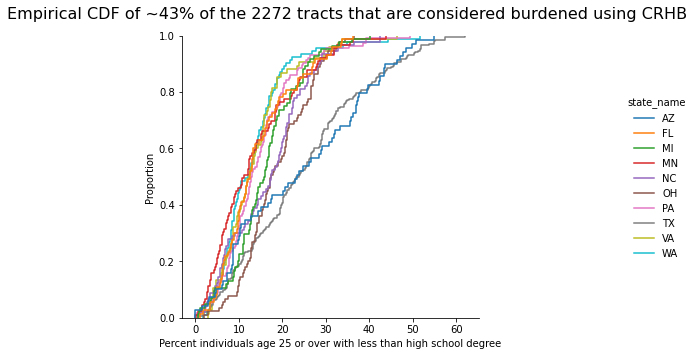

In [138]:
ax2 = sns.displot(data=representative_calenvironscreen,
            x='Percent individuals age 25 or over with less than high school degree', hue="state_name", kind="ecdf")

ax2.fig.subplots_adjust(top=0.9)
ax2.fig.suptitle("Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB", fontsize=16)

Text(0.5, 0.98, 'Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB')

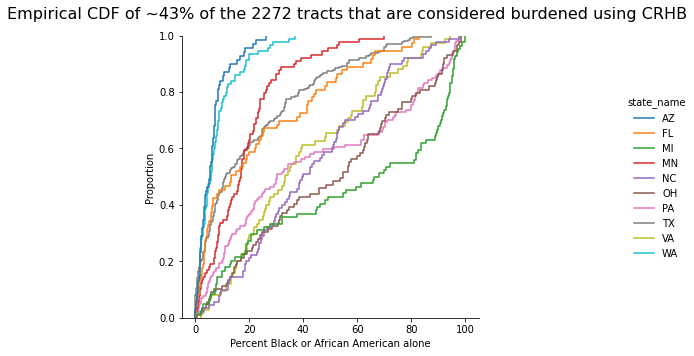

In [139]:
# split - WA, AZ exceptions

ax1 = sns.displot(data=representative_calenvironscreen,
            x="Percent Black or African American alone", hue="state_name", kind="ecdf")

ax1.fig.subplots_adjust(top=0.9)
ax1.fig.suptitle("Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB", fontsize=16)

Text(0.5, 0.98, 'Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB')

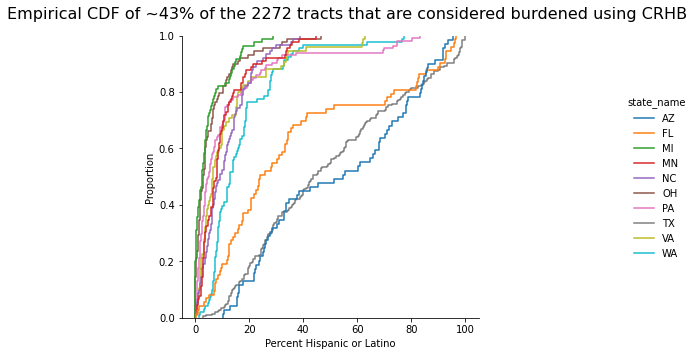

In [140]:
ax = sns.displot(data=representative_calenvironscreen,
            x="Percent Hispanic or Latino", hue="state_name", kind="ecdf")

ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle("Empirical CDF of ~43% of the 2272 tracts that are considered burdened using CRHB", fontsize=16)

In [142]:
representative_calenvironscreen.state_name.value_counts()

TX    206
PA    114
WA     93
NC     90
MN     89
OH     89
MI     84
VA     75
FL     73
AZ     69
Name: state_name, dtype: int64

In [37]:
merged_df_score_ejcreen.shape

(2272, 36)

In [38]:
grouped_stats_score_ej_screen['Total Number of Unique Tracts'].sum()

2272

In [39]:
values_2 = list(grouped_stats_score_ej_screen[list_of_columns].mean())

In [40]:
values_2.extend([False, True])

#### Both Met Criterion

In [41]:
predicate_3 = (non_null_df['current_threshold_exceeded'] == True) & (non_null_df['new_threshold_exceeded'] == True)

union_df = non_null_df[predicate_3]

In [42]:
union_df.shape

(4529, 15)

In [241]:
# Join the demographics in.
merged_df_both_met = union_df.merge(
    demographics_df[columns_to_keep],
    left_on="FIPS_tract_id",
    right_on="GEOID10_TRACT",
    how="inner"
)

# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in merged_df_both_met.columns if 
                'Percent' in x or '(percent)' in x
    ]

merged_df_both_met[
    percent_cols] = merged_df_both_met[
    percent_cols].apply(lambda x: x * 100)

for idx, row in merged_df_both_met.iterrows():
    current_row = str(merged_df_both_met.loc[idx, 'state'])
    state = mapping.get(current_row, None)
    merged_df_both_met.loc[idx, 'state_name'] = state

grouped_stats_both_met = merged_df_both_met.groupby(["state_name"]).agg({
       'GEOID10_TRACT': 'nunique',
       'Percent of individuals < 200% Federal Poverty Line': [np.median, np.std],
       'Median value ($) of owner-occupied housing units': [np.median, np.std],
       'Percent individuals age 25 or over with less than high school degree': [np.median, np.std],
       'Percent enrollment in college or graduate school': [np.median, np.std],
       'Percent Black or African American alone': [np.median, np.std],
       'Percent American Indian and Alaska Native alone': [np.median, np.std],
       'Percent Non-Hispanic White': [np.median, np.std], 
      'Linguistic isolation (percent)': [np.median, np.std],
       'Percent Hispanic or Latino': [np.median, np.std],
      'hbrd_rank': [np.median, np.std],
      'current_methodology_percent': [np.median, np.std],
      'current_summed_methodology': [np.median, np.std, np.sum]
}).reset_index()


grouped_stats_both_met.columns = [' '.join(col).strip() for 
                                 col in grouped_stats_both_met.columns.values]

grouped_stats_both_met = grouped_stats_both_met[[x for x in grouped_stats_both_met 
               if "median" in x and 
               "Percent" in x] + ["GEOID10_TRACT nunique", 
                                  'current_summed_methodology sum', "state_name"]]

grouped_stats_both_met.set_index("state_name", inplace=True)

grouped_stats_both_met = grouped_stats_both_met.rename(columns={
'Percent of individuals < 200% Federal Poverty Line median'
    : 'Percent of individuals < 200% Federal Poverty Line (median across all tracts)', 
'Percent individuals age 25 or over with less than high school degree median':
'Percent individuals age 25 or over with less than high school degree (median across all tracts)',    
'Percent enrollment in college or graduate school median'
    :'Percent enrollment in college or graduate school (median across all tracts)',
'Percent Black or African American alone median':
    'Percent Black or African American alone (median across all tracts)',
'Percent American Indian and Alaska Native alone median':
    'Percent American Indian and Alaska Native alone (median across all tracts)',
'Percent Non-Hispanic White median':
    'Percent Non-Hispanic White (median across all tracts)',
'Percent Hispanic or Latino median':
    'Percent Hispanic or Latino (median across all tracts)',
'GEOID10_TRACT nunique': "Total Number of Unique Tracts",
"current_summed_methodology sum": "Total Owned and Rented Burdened Households (Current Aggregation Methodology)"    
})

In [242]:
values_3 = list(grouped_stats_both_met[list_of_columns].mean())

In [243]:
values_3.extend([True, True])

#### Neither Met Criterion 

In [244]:
predicate_4 = (non_null_df[
    'current_threshold_exceeded'] == False) & (
    non_null_df['new_threshold_exceeded'] == False)

negation_union_df = non_null_df[predicate_4]

In [245]:
# Join the demographics in.
merged_df_negation_union = negation_union_df.merge(
    demographics_df[columns_to_keep],
    left_on="FIPS_tract_id",
    right_on="GEOID10_TRACT",
    how="inner"
)

# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in merged_df_negation_union.columns if 
                'Percent' in x or '(percent)' in x
    ]

merged_df_negation_union[
    percent_cols] = merged_df_negation_union[
    percent_cols].apply(lambda x: x * 100)

for idx, row in merged_df_negation_union.iterrows():
    current_row = str(merged_df_negation_union.loc[idx, 'state'])
    state = mapping.get(current_row, None)
    merged_df_negation_union.loc[idx, 'state_name'] = state

grouped_stats_both_not_met = merged_df_negation_union.groupby(["state_name"]).agg({
       'GEOID10_TRACT': 'nunique',
       'Percent of individuals < 200% Federal Poverty Line': [np.median, np.std],
       'Median value ($) of owner-occupied housing units': [np.median, np.std],
       'Percent individuals age 25 or over with less than high school degree': [np.median, np.std],
       'Percent enrollment in college or graduate school': [np.median, np.std],
       'Percent Black or African American alone': [np.median, np.std],
       'Percent American Indian and Alaska Native alone': [np.median, np.std],
       'Percent Non-Hispanic White': [np.median, np.std], 
      'Linguistic isolation (percent)': [np.median, np.std],
       'Percent Hispanic or Latino': [np.median, np.std],
      'hbrd_rank': [np.median, np.std],
      'current_methodology_percent': [np.median, np.std],
      'current_summed_methodology': [np.median, np.std, np.sum]
}).reset_index()


grouped_stats_both_not_met.columns = [' '.join(col).strip() for 
                                 col in grouped_stats_both_not_met.columns.values]

grouped_stats_both_not_met = grouped_stats_both_not_met[[x for x in grouped_stats_both_not_met 
               if "median" in x and 
               "Percent" in x] + ["GEOID10_TRACT nunique", 
                                  'current_summed_methodology sum', "state_name"]]

grouped_stats_both_not_met.set_index("state_name", inplace=True)

grouped_stats_both_not_met = grouped_stats_both_not_met.rename(columns={
'Percent of individuals < 200% Federal Poverty Line median'
    : 'Percent of individuals < 200% Federal Poverty Line (median across all tracts)', 
'Percent individuals age 25 or over with less than high school degree median':
'Percent individuals age 25 or over with less than high school degree (median across all tracts)',    
'Percent enrollment in college or graduate school median'
    :'Percent enrollment in college or graduate school (median across all tracts)',
'Percent Black or African American alone median':
    'Percent Black or African American alone (median across all tracts)',
'Percent American Indian and Alaska Native alone median':
    'Percent American Indian and Alaska Native alone (median across all tracts)',
'Percent Non-Hispanic White median':
    'Percent Non-Hispanic White (median across all tracts)',
'Percent Hispanic or Latino median':
    'Percent Hispanic or Latino (median across all tracts)',
'GEOID10_TRACT nunique': "Total Number of Unique Tracts",
"current_summed_methodology sum": "Total Owned and Rented Burdened Households (Current Aggregation Methodology)"    
})

In [246]:
values_4 = list(grouped_stats_both_not_met[list_of_columns].mean())

values_4.extend([False, False])

In [247]:
final_summary_data_values = [values_1, values_2, values_3, values_4]
 
# Create the pandas DataFrame
df = pd.DataFrame(final_summary_data_values)
 
df

,0,1,2,3,4,5,6,7,8,9,10
0,57.052724,19.383813,8.132533,33.692806,1.221395,31.321886,19.378348,62.088889,40949.200000,True,False
1,47.082927,13.224927,8.685441,23.061683,0.772400,48.240042,12.553371,44.549020,24719.098039,False,True
2,62.331263,17.689811,11.824205,33.455525,0.921755,34.495797,15.855933,88.803922,60757.901961,True,True
3,27.736502,8.785280,5.847120,5.729181,0.537429,75.916536,7.463468,1244.333333,443680.568627,False,False


In [248]:
cols = list(grouped_stats_both_not_met.columns)
cols.extend([
             'Score L Relative Housing Burden for all households met burden threshold',                     
             'CalEnviroScreen Housing Burden Met Burden Threshold (Ranked Percentile)'])

In [249]:
df.rename(columns={df.columns[idx]: cols[idx] for idx, _ in enumerate(cols)}, inplace=True)

In [250]:
df = df.set_index([
             'Score L Relative Housing Burden for all households met burden threshold',                     
             'CalEnviroScreen Housing Burden Met Burden Threshold (Ranked Percentile)'], inplace=False)

In [251]:
df = df.rename(columns={
'Percent of individuals < 200% Federal Poverty Line (median across all tracts)'
    : 'Percent of individuals < 200% Federal Poverty Line (mean of median across all states)', 
'Percent individuals age 25 or over with less than high school degree median':
'Percent individuals age 25 or over with less than high school degree (mean of median across all states)',    
'Percent enrollment in college or graduate school (median across all states)'
    :'Percent enrollment in college or graduate school (mean of median across all states)',
'Percent Black or African American alone (median across all tracts)':
    'Percent Black or African American alone (mean of median across all states)',
'Percent American Indian and Alaska Native alone (median across all tracts)':
    'Percent American Indian and Alaska Native alone (mean of median across all states)',
'Percent Non-Hispanic White (median across all tracts)':
    'Percent Non-Hispanic White (mean of median across all states)',
'Percent Hispanic or Latino (median across all tracts)':
    'Percent Hispanic or Latino (mean of median across all states)',
"Total Number of Unique Tracts": "Total Number of Tracts - Mean of median across all states",
"Total Owned and Rented Burdened Households (Current Aggregation Methodology)": "Total Owned and Rented Burdened Households (Current Aggregation Methodology)- Mean of median across all states"
})

In [252]:
df

,,Percent of individuals < 200% Federal Poverty Line (mean of median across all states),Percent individuals age 25 or over with less than high school degree (median across all tracts),Percent enrollment in college or graduate school (median across all tracts),Percent Black or African American alone (mean of median across all states),Percent American Indian and Alaska Native alone (mean of median across all states),Percent Non-Hispanic White (mean of median across all states),Percent Hispanic or Latino (mean of median across all states),Total Number of Tracts - Mean of median across all states,Total Owned and Rented Burdened Households (Current Aggregation Methodology)- Mean of median across all states
Score L Relative Housing Burden for all households met burden threshold,CalEnviroScreen Housing Burden Met Burden Threshold (Ranked Percentile),,,,,,,,,
True,False,57.052724,19.383813,8.132533,33.692806,1.221395,31.321886,19.378348,62.088889,40949.200000
False,True,47.082927,13.224927,8.685441,23.061683,0.772400,48.240042,12.553371,44.549020,24719.098039
True,True,62.331263,17.689811,11.824205,33.455525,0.921755,34.495797,15.855933,88.803922,60757.901961
False,False,27.736502,8.785280,5.847120,5.729181,0.537429,75.916536,7.463468,1244.333333,443680.568627


In [211]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_styled = df.style.format(
                na_rep='MISSING',
                formatter={df.columns[idx]: "{:.2f}" for idx, _ in enumerate(df.columns) })

In [255]:
df_styled_max_min = df_styled.apply(highlight_max, props='color:#FFFFFF;background-color:#00008b', axis=0)\
    .apply(highlight_min, props='color:#FFFFFF;background-color:#FF0000', axis=0)

In [256]:
df_styled_max_min.to_excel("summary_all_states.xlsx")

In [257]:
df_styled_max_min

,,Percent of individuals < 200% Federal Poverty Line (mean of median across all states),Percent individuals age 25 or over with less than high school degree (median across all tracts),Percent enrollment in college or graduate school (median across all tracts),Percent Black or African American alone (mean of median across all states),Percent American Indian and Alaska Native alone (mean of median across all states),Percent Non-Hispanic White (mean of median across all states),Percent Hispanic or Latino (mean of median across all states),Total Number of Tracts - Mean of median across all states,Total Owned and Rented Burdened Households (Current Aggregation Methodology)- Mean of median across all states
Score L Relative Housing Burden for all households met burden threshold,CalEnviroScreen Housing Burden Met Burden Threshold (Ranked Percentile),,,,,,,,,
True,False,57.05,19.38,8.13,33.69,1.22,31.32,19.38,62.09,40949.20
False,True,47.08,13.22,8.69,23.06,0.77,48.24,12.55,44.55,24719.10
True,True,62.33,17.69,11.82,33.46,0.92,34.50,15.86,88.80,60757.90
False,False,27.74,8.79,5.85,5.73,0.54,75.92,7.46,1244.33,443680.57


In [270]:
df_1 = pd.read_excel("score_l_burdened_not_calenviroscreen.xlsx", engine='openpyxl')
df_1.set_index("state_name", inplace=True)
df_2 = pd.read_excel("calenviroscreen_summary.xlsx", engine='openpyxl')
df_2.set_index("state_name", inplace=True)

In [272]:
df_1.head(2)

,Percent of individuals < 200% Federal Poverty Line (median across all tracts),Percent individuals age 25 or over with less than high school degree (median across all tracts),Percent enrollment in college or graduate school (median across all tracts),Percent Black or African American alone (median across all tracts),Percent American Indian and Alaska Native alone (median across all tracts),Percent Non-Hispanic White (median across all tracts),Percent Hispanic or Latino (median across all tracts),Total Number of Unique Tracts,Total Owned and Rented Burdened Households (Current Aggregation Methodology)
state_name,,,,,,,,,
AK,33.563081,10.407240,9.485638,4.553571,21.279762,48.839286,9.375000,1,825
AL,63.335854,20.273617,7.895408,79.236090,0.000000,8.436779,1.986055,14,7107


In [273]:
candidate_columns = ['Percent of individuals < 200% Federal Poverty Line (median across all tracts)',
       'Percent individuals age 25 or over with less than high school degree (median across all tracts)',
       'Percent enrollment in college or graduate school (median across all tracts)',
       'Percent Black or African American alone (median across all tracts)',
       'Percent American Indian and Alaska Native alone (median across all tracts)',
       'Percent Non-Hispanic White (median across all tracts)',
       'Percent Hispanic or Latino (median across all tracts)',
       'Total Number of Unique Tracts',
       'Total Owned and Rented Burdened Households (Current Aggregation Methodology)']

In [276]:
diff = (df_1[candidate_columns] - df_2[candidate_columns]).fillna(0)

In [277]:
diff.head()

,Percent of individuals < 200% Federal Poverty Line (median across all tracts),Percent individuals age 25 or over with less than high school degree (median across all tracts),Percent enrollment in college or graduate school (median across all tracts),Percent Black or African American alone (median across all tracts),Percent American Indian and Alaska Native alone (median across all tracts),Percent Non-Hispanic White (median across all tracts),Percent Hispanic or Latino (median across all tracts),Total Number of Unique Tracts,Total Owned and Rented Burdened Households (Current Aggregation Methodology)
state_name,,,,,,,,,
AK,0.985223,-0.274578,3.206568,-1.085258,8.721076,-6.803172,-1.778285,-10.0,-4179.0
AL,6.211917,4.283941,0.331430,6.212278,0.000000,-9.011147,-0.630017,-28.0,-15422.0
AR,5.432052,1.601861,3.942754,20.319049,0.102459,-23.263854,-0.896646,-35.0,-16843.0
AZ,13.594871,11.979424,-0.272040,1.361388,-0.915677,-8.953361,8.757832,-39.0,-23253.0
CA,15.717598,16.799587,-0.702951,0.247647,0.415820,-21.870519,40.216194,783.0,542144.0


In [279]:
def style_negative(v, props=''):
    return props if v < 0 else None

diff_style = diff.style.applymap(style_negative, props='color:red;')\
              .applymap(lambda v: 'opacity: 20%;' if (v < 0.0) and (v > 0.0) else None)
diff_style

,Percent of individuals < 200% Federal Poverty Line (median across all tracts),Percent individuals age 25 or over with less than high school degree (median across all tracts),Percent enrollment in college or graduate school (median across all tracts),Percent Black or African American alone (median across all tracts),Percent American Indian and Alaska Native alone (median across all tracts),Percent Non-Hispanic White (median across all tracts),Percent Hispanic or Latino (median across all tracts),Total Number of Unique Tracts,Total Owned and Rented Burdened Households (Current Aggregation Methodology)
state_name,,,,,,,,,
AK,0.985223,-0.274578,3.206568,-1.085258,8.721076,-6.803172,-1.778285,-10.000000,-4179.000000
AL,6.211917,4.283941,0.331430,6.212278,0.000000,-9.011147,-0.630017,-28.000000,-15422.000000
AR,5.432052,1.601861,3.942754,20.319049,0.102459,-23.263854,-0.896646,-35.000000,-16843.000000
AZ,13.594871,11.979424,-0.272040,1.361388,-0.915677,-8.953361,8.757832,-39.000000,-23253.000000
CA,15.717598,16.799587,-0.702951,0.247647,0.415820,-21.870519,40.216194,783.000000,542144.000000
CO,5.267963,0.816207,0.089370,5.338649,0.149809,-24.425903,10.133080,-34.000000,-17296.000000
CT,20.337916,6.865214,0.574592,-7.952396,0.000000,-9.384233,3.734253,48.000000,33786.000000
DC,20.225619,9.277701,-10.589364,65.946763,0.000000,-49.789447,-6.124777,13.000000,9673.000000
DE,1.370275,-1.231413,-4.499021,-27.806872,0.581898,9.572051,6.704117,-8.000000,-2816.000000
